# 4. Hypoglycaemic episodes
This notebook looks into the identification of hypoglycaemic episodes from the data created in [section 1](..file-types/1_create_df.ipynb). Episodes are identified in 5-minute data, cut 15-minute data, and interpolated 5-minute data (from the 15-minute data). These episodes are recorded with start and end time, which are then used to check if they overlap with the 5-minute dataset. This is used to determine the number of true positives, false positives and false negatives, compare to the 5-minute 'gold standard'. The results are stored in results_frame at the end of section 3.2 and are divided into all hypoglycaemic episodes, level 1 and level 2 episodes.
Section 3.3. then shows a figure with some examples of how the interpolation can be correct and incorrect and section 3.4. shows the what the incorrect level 1 and level 2 hypos are labelled as.

## 4.1. Import packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib.dates as mdates
import sys
sys.path.append("/Users/cr591/OneDrive - University of Exeter/Desktop/diametrics/diametrics")
import metrics as cgm
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#df_minute = pd.read_csv('~/OneDrive - University of Exeter/Desktop/PhD/Projects/interpolation-for-hypo-detection/dexcom-maths-exploration/data/tidy_data/interp_dataset.csv')
df_minute = pd.read_csv('interp_dataset.csv')
df_minute['time'] = pd.to_datetime(df_minute['time'])
df = df_minute.dropna(subset=['glc'])

In [4]:
cols = ['cut_glc', 'pchip', 'linear', 'cubicspline', 'akima', 'polynomial_3', 
        'polynomial_5', 'polynomial_7', 'matern', 'rq', 'rbf']

## 4.2. Identify hypoglycaemic episodes

In [5]:
# Use diametrics 'breakdown' feature to identify the start and end time of
# hypoglycaemic episodes
df[cols] = df[cols].round(2)
df_results = cgm.hypoglycemic_episodes(df, 'time', 'glc', 'ID', 
                                       interpolate=False, breakdown=True)
df_results.head()

,ID,start_time,end_time,low,lv2
0,1003_6months,2018-09-21 16:07:00,2018-09-21 18:52:00,2.22,True
1,1003_6months,2018-09-22 00:07:00,2018-09-22 00:27:00,2.39,False
2,1003_6months,2018-09-22 03:07:00,2018-09-22 04:17:00,3.16,False
3,1003_6months,2018-09-23 13:17:00,2018-09-23 13:57:00,2.83,False
4,1003_6months,2018-09-23 23:07:00,2018-09-23 23:42:00,2.66,False


In [36]:
def overlapping_frame(row, dataframe):
    '''
    Returns all rows of the dataframe with that overlap with the start and end
    end time of the row
    '''
    return dataframe.loc[(dataframe['ID'] == row['ID']) &
                         (((dataframe['start_time'] <= row['start_time']) &
                           (dataframe['end_time'] >= row['start_time']))|
                          ((dataframe['start_time'] <= row['end_time']) &
                           (dataframe['end_time'] >= row['end_time'])) |
                          ((row['start_time'] <= dataframe['start_time']) &
                           (row['end_time'] >= dataframe['start_time']))|
                          ((row['start_time'] <= dataframe['end_time']) &
                           (row['end_time'] >= dataframe['end_time'])))]

In [37]:
def calculate_confusion_matrix(original_df, comparison_df, col, aligned=False):
    '''
    Takes two dataframes with hypoglycaemic episode breakdown and identifies
    the number of true positives (TP), false positives (FP) and false negatives
    (FN) of the comparison_df compared to the original_df
    '''
    # Set variables to zero
    false_positive = 0
    true_positive = 0
    false_negative = 0
    # Go through every row in the original_df
    for i, row in original_df.iterrows():
        # Get the overlapping rows from comparison_df
        sub_df = overlapping_frame(row, comparison_df)
        # If the there are no overlapping rows, add 1 to FNs
        if sub_df.shape[0] == 0:
            false_negative += 1
            # Add details to aligned_results - start and end times of bout
            if aligned:
                aligned_results.append({'col': col, 'ID': row.ID, 
                      'global_start':row['start_time'], 
                      '5_min start':row['start_time'], 
                      '5_min_end':row['end_time'], 
                      '5_min_diff':row['end_time']- row['start_time'],
                      '5_min_lv2': row['lv2'],
                      'false_value':-1})
        # If there is 1 overlapping row, add 1 to TP
        elif sub_df.shape[0] == 1:
            true_positive += 1
            # Drop the first entry in the comparison dataframe as they'll be
            # counted again later to assess FPs
            comparison_df = comparison_df.drop(index=sub_df.index[0])
            # Add details to aligned_results
            if aligned:
                aligned_results.append({'col':col, 'ID':row.ID, 
                           'global_start':row['start_time'], 
                           '5_min start':row['start_time'], 
                           '5_min_end':row['end_time'], 
                          '5_min_diff':row['end_time']- row['start_time'], 
                          '5_min_lv2':row['lv2'], 
                          '15_min start':sub_df.iloc[0]['start_time'], 
                          '15_min_end':sub_df.iloc[0]['end_time'], 
                          '15_min_diff':sub_df.iloc[0]['end_time'] -
                                        sub_df.iloc[0]['start_time'], 
                          '15_min_lv2':sub_df.iloc[0]['lv2'], 'false_value':0})

        # If there is more than 1 overlapping row, add 1 to TP and the rest to 
        # FN
        elif sub_df.shape[0] > 1:
            true_positive += 1
            # Drop the first entry in the comparison dataframe as before
            comparison_df = comparison_df.drop(index=sub_df.index[0])
            if aligned:
                # Add details to aligned_results
                aligned_results.append({'col': col, 'ID': row.ID,
                           'global_start': row['start_time'],
                           '5_min start': row['start_time'],
                           '5_min_end': row['end_time'],
                          '5_min_diff': row['end_time']- row['start_time'],
                          '5_min_lv2': row['lv2'], 
                          '15_min start': sub_df.iloc[0]['start_time'],
                          '15_min_end': sub_df.iloc[0]['end_time'],
                          '15_min_diff': sub_df.iloc[0]['end_time'] -
                                        sub_df.iloc[0]['start_time'],
                          '15_min_lv2': sub_df.iloc[0]['lv2'],
                                        'false_value':0})
    # Now loop through the remaining rows in the comparison_df that haven't
    # already been paired, add them all as FPs
    for i, row in comparison_df.iterrows():
        false_positive += 1
        if aligned:
            # Add the details to aligned results
            aligned_results.append({'col':col, 'ID':row.ID,
                           'global_start':row['start_time'],
                          '15_min start':row['start_time'],
                          '15_min_end':row['end_time'],
                          '15_min_diff':row['end_time'] - 
                                    sub_df.iloc[0]['start_time'],
                          '15_min_lv2':row['lv2'], 'false_value':+1})
    return [true_positive, false_negative, false_positive]

In [38]:
# Declare lists for results
aligned_results = []
results_list = []
# For all of the interpolation methods, calculate hypos and compare with 
# calculate_confusion_matrix
for col in cols:
    # Select method and rename columns
    sub_df = df[['time', 'ID', col]]
    sub_df.columns = ['time', 'ID', 'glc']
    # Set the interval to 15 mins for the cut_glc column
    if col == 'cut_glc': 
        interval_size=15 
    else: 
        interval_size=5
    # Calculate number of hypoglycaemic episodes for column
    cut_results = cgm.hypoglycemic_episodes(sub_df, 'time', 'glc', 'ID',
                                                interpolate=False,
                                                breakdown=True,
                                                interval_size=interval_size)
    # Calculate confusion matrix for all hypos and created aligned_results
    # with breakdown comparison
    results_list.append([col, 'all'] + calculate_confusion_matrix(df_results,
                                                                  cut_results,
                                                                  col,
                                                                  aligned=True))
    # Calculate confusion matrix for level 1 hypos only
    lv1_results = cut_results[cut_results['lv2'] == False].reset_index(drop=True)
    df_lv1 = df_results[df_results['lv2'] == False].reset_index(drop=True)
    results_list.append([col, 'lv1'] + calculate_confusion_matrix(df_lv1, 
                                                                  lv1_results, 
                                                                  col))
    # Calculate confusion matrix for level 2 hypos only
    lv2_results = cut_results[cut_results['lv2'] == True].reset_index(drop=True)
    df_lv2 = df_results[df_results['lv2'] == True].reset_index(drop=True)
    results_list.append([col, 'lv2'] + calculate_confusion_matrix(df_lv2, 
                                                                  lv2_results, 
                                                                  col))

results_frame = pd.DataFrame(results_list, columns=['method', 'lv', 'TP', 'FN', 
                                                    'FP'])
aligned_results = pd.DataFrame(aligned_results)

In [39]:
# Calculate recall, precision and critical success index
results_frame['recall'] = results_frame['TP']/(results_frame['TP'] +
                                               results_frame['FN'])
results_frame['prec'] = results_frame['TP']/(results_frame['TP'] +
                                             results_frame['FP'])
results_frame['csi'] = results_frame['TP']/(results_frame['TP'] +
                                            results_frame['FP'] +
                                            results_frame['FN'])
# Sort by level, then recall, then csi
results_frame = results_frame.sort_values(['lv', 'recall', 'csi'],
                                          ascending=True)

In [47]:
results_frame.round(3)

,method,lv,TP,FN,FP,recall,prec,csi
0,cut_glc,all,465,36,2,0.928,0.996,0.924
6,linear,all,482,19,6,0.962,0.988,0.951
27,rq,all,484,17,11,0.966,0.978,0.945
30,rbf,all,490,11,18,0.978,0.965,0.944
12,akima,all,490,11,14,0.978,0.972,0.951
21,polynomial_7,all,491,10,18,0.980,0.965,0.946
3,pchip,all,491,10,10,0.980,0.980,0.961
24,matern,all,492,9,18,0.982,0.965,0.948
9,cubicspline,all,492,9,15,0.982,0.970,0.953
15,polynomial_3,all,492,9,15,0.982,0.970,0.953


In [42]:
# Sort by col, then ID, then start time
aligned_results.sort_values(['col', 'ID', 'global_start']).head()

,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value
2037,akima,1003_6months,2018-09-21 16:07:00,2018-09-21 16:07:00,2018-09-21 18:52:00,0 days 02:45:00,True,2018-09-21 16:02:00,2018-09-21 18:52:00,0 days 02:50:00,True,0
2038,akima,1003_6months,2018-09-22 00:07:00,2018-09-22 00:07:00,2018-09-22 00:27:00,0 days 00:20:00,False,2018-09-22 00:07:00,2018-09-22 00:27:00,0 days 00:20:00,False,0
2039,akima,1003_6months,2018-09-22 03:07:00,2018-09-22 03:07:00,2018-09-22 04:17:00,0 days 01:10:00,False,2018-09-22 03:07:00,2018-09-22 04:17:00,0 days 01:10:00,False,0
2040,akima,1003_6months,2018-09-23 13:17:00,2018-09-23 13:17:00,2018-09-23 13:57:00,0 days 00:40:00,False,2018-09-23 13:17:00,2018-09-23 13:57:00,0 days 00:40:00,False,0
2041,akima,1003_6months,2018-09-23 23:07:00,2018-09-23 23:07:00,2018-09-23 23:42:00,0 days 00:35:00,False,2018-09-23 23:12:00,2018-09-23 23:42:00,0 days 00:30:00,False,0


In [15]:
def create_ax(sub_df, ax, method, colour, line2=True):
    sub_df_5 = sub_df.dropna(subset=['glc'])
    no_15 = sub_df_5[pd.isnull(sub_df_5.cut_glc)]
    ax.plot(no_15.time, no_15.glc,'x', label='5 min readings', markersize= 5)

    ax.plot(sub_df.time, sub_df[method], linestyle='--', color=colour, linewidth=1)
    ax.plot(no_15.time, no_15[method], marker='^', color=colour, linestyle='None',
       markersize=4, label='Interpolated readings')
    ax.plot(sub_df_5.time, sub_df_5.cut_glc, marker='o', color='C3', linestyle='None',
        label='15 min readings', markersize=5)

    # Lines to show hypo and hyper-glycemia
    ax.hlines(y=3.9, color='tab:gray', linestyles='dotted', xmin=sub_df.time.min(), 
           xmax=sub_df.time.max(), label='Level 1 hypo')
    if line2==True:
        ax.hlines(y=3, color='tab:gray', linestyles='dotted',xmin=sub_df.time.min(), 
               xmax=sub_df.time.max(), label='Lv2 hypo')

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    #ax.legend()
    ax.set_ylabel('Glucose (mmol/L)')
    ax.set_xlabel('Time')
    return ax

In [16]:
sub_dfs = [df[(df.ID=='1007_baseline') & (df.time>='2018-01-11 20:40') & (df.time<='2018-01-11 21:05')],
            df[(df.ID=='2003_6months') & (df.time>='2018-09-13 19:20') & (df.time<='2018-09-13 19:55')], #lv1 FP
            df[(df.ID=='1030_baseline') & (df.time>='13/03/2018 14:15') & (df.time<='13/03/2018 14:48')], # lv2 fn
            df[(df.ID=='1040_6months') & (df.time>='2018-12-05 11:40') & (df.time<='2018-12-05 12:40')],
            #df[(df.ID=='2028_baseline') & (df.time>='2018-03-08 21:00') & (df.time<='2018-03-09 01:45')], # lv2 fp
            #df[(df.ID=='1034_6months') & (df.time>='2019-01-19 10:30') & (df.time<='2019-01-19 12:05')],
            df[(df.ID=='2032_baseline') & (df.time>='2018-03-23 14:50') & (df.time<='2018-03-23 15:20')],
            df[(df.ID=='1013_6months') & (df.time>='2018-09-22 19:20') & (df.time<='2018-09-22 22:00')]] 

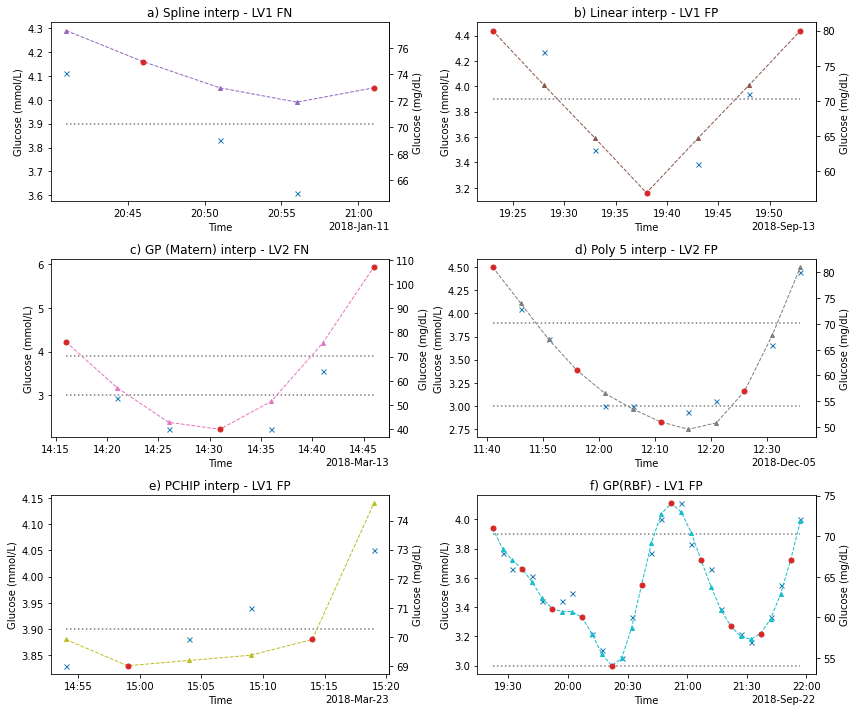

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12, 10))
ax1 = create_ax(sub_dfs[0], ax1, 'cubicspline', 'C4', False)
ax1.set_title('a) Spline interp - LV1 FN')
ax2 = create_ax(sub_dfs[1], ax2, 'linear', 'C5', False)
ax2.set_title('b) Linear interp - LV1 FP')
ax3 = create_ax(sub_dfs[2], ax3, 'matern', 'C6', True)
ax3.set_title('c) GP (Matern) interp - LV2 FN')
ax4 = create_ax(sub_dfs[3], ax4, 'polynomial_5', 'C7', True)
ax4.set_title('d) Poly 5 interp - LV2 FP')
ax5 = create_ax(sub_dfs[4], ax5, 'pchip', 'C8',False)
ax5.set_title('e) PCHIP interp - LV1 FP')
ax6 = create_ax(sub_dfs[5], ax6, 'rbf', 'C9',True)
ax6.set_title('f) GP(RBF) - LV1 FP')

for ax in ax1, ax2, ax3, ax4, ax5, ax6:
    secax = ax.secondary_yaxis('right', functions=(mmol2mg, mg2mmol))
    secax.set_ylabel('Glucose (mg/dL)')
fig.tight_layout()
#fig.show()
#fig.savefig('fn_tp_examples.png')

In [228]:
# Save dataframes
results_frame.round(3).to_csv('confusion_matrix_hypos.csv', index=False)
aligned_results.sort_values(['col', 'ID', 'global_start']).to_csv('aligned_results_rounded.csv', index=False)

## 4.3. Type of incorrect results

In [112]:
aligned_results['false_lv2'] = aligned_results['15_min_lv2'] - aligned_results['5_min_lv2']

In [113]:
aligned_cut = aligned_results.loc[aligned_results['col']=='cut_glc']

In [139]:
aligned_results.sort_values(['col', 'ID', 'global_start'], inplace=True)
aligned_results.reset_index(inplace=True, drop=True)

In [146]:
def overlaps(start_1, end_1, start_2, end_2):
    if ((start_1<start_2) & (end_1>start_2)) | ((start_2<start_1) & (end_2>start_1)): #| ((start_1>start_2) & (end_1<end_2)) | ((start_1<start_2) & (end_1>end_2)):
        return True
    else:
        return False

In [171]:
def col_calc(df):
    split_fns = 0
    split_fps = 0
    split_fns_lv2 = 0
    split_fps_lv2 = 0
    for i, row in df.iterrows():
        try:
            above = df.loc[i-1]
        except:
            continue
        if row.false_value == -1:
            if row.ID == above.ID:
                if overlaps(row['5_min start'], row['5_min_end'], above['15_min start'], above['15_min_end']) == True:
                    split_fns += 1
                    if row['5_min_lv2'] == True:
                        split_fns_lv2 += 1

        if row.false_value == 1:
            if row.ID == above.ID:
                    if overlaps(above['5_min start'], above['5_min_end'], row['15_min start'], row['15_min_end']) == True:
                        split_fps += 1
                        print(row.col, row.ID)
                        if row['15_min_lv2'] == True:
                            split_fps_lv2 += 1
    return pd.DataFrame([[split_fns, split_fns_lv2, split_fps, split_fps_lv2]], columns = ['split_fns', 'split_fns_lv2', 'split_fps', 'split_fps_lv2'])

In [172]:
split_results = aligned_results.groupby('col').apply(lambda group: col_calc(group))

akima 1013_6months
akima 1013_6months
akima 1042_baseline
akima 2012_6months
cubicspline 1013_6months
cubicspline 1013_6months
cubicspline 1042_baseline
cubicspline 2012_6months
cut_glc 1042_baseline
linear 1042_baseline
matern 1013_6months
matern 1013_6months
matern 1042_baseline
matern 2012_6months
pchip 1013_6months
pchip 1042_baseline
pchip 2012_6months
polynomial_3 1013_6months
polynomial_3 1013_6months
polynomial_3 1042_baseline
polynomial_3 2012_6months
polynomial_5 1013_6months
polynomial_5 1013_6months
polynomial_5 1042_baseline
polynomial_5 2012_6months
polynomial_7 1013_6months
polynomial_7 1013_6months
polynomial_7 1042_baseline
polynomial_7 2012_6months
rbf 1013_6months
rbf 1013_6months
rbf 1042_baseline
rbf 2012_6months
rq 1013_6months
rq 1042_baseline
rq 2012_6months


In [163]:
split_results

,,split_fns,split_fns_lv2,split_fps,split_fps_lv2
col,,,,,
akima,0,0,0,4,1
cubicspline,0,0,0,4,1
cut_glc,0,3,2,1,1
linear,0,1,0,1,1
matern,0,1,1,4,1
pchip,0,0,0,3,1
polynomial_3,0,0,0,4,1
polynomial_5,0,0,0,4,1
polynomial_7,0,0,0,4,1


In [157]:
aligned_cut

,index,col,ID,global_start,5_min start,5_min_end,5_min_diff,5_min_lv2,15_min start,15_min_end,15_min_diff,15_min_lv2,false_value,ID_code,false_lv2
0,0,cut_glc,1003_6months,2018-09-21 16:07:00,2018-09-21 16:07:00,2018-09-21 18:52:00,0 days 02:45:00,True,2018-09-21 16:07:00,2018-09-21 18:52:00,0 days 02:45:00,True,0,1003,0
1,1,cut_glc,1003_6months,2018-09-22 00:07:00,2018-09-22 00:07:00,2018-09-22 00:27:00,0 days 00:20:00,False,2018-09-22 00:07:00,2018-09-22 00:22:00,0 days 00:15:00,False,0,1003,0
2,2,cut_glc,1003_6months,2018-09-22 03:07:00,2018-09-22 03:07:00,2018-09-22 04:17:00,0 days 01:10:00,False,2018-09-22 03:07:00,2018-09-22 04:07:00,0 days 01:00:00,False,0,1003,0
3,3,cut_glc,1003_6months,2018-09-23 13:17:00,2018-09-23 13:17:00,2018-09-23 13:57:00,0 days 00:40:00,False,2018-09-23 13:22:00,2018-09-23 13:52:00,0 days 00:30:00,False,0,1003,0
4,4,cut_glc,1003_6months,2018-09-23 23:07:00,2018-09-23 23:07:00,2018-09-23 23:42:00,0 days 00:35:00,False,2018-09-23 23:17:00,2018-09-23 23:32:00,0 days 00:15:00,False,0,1003,0
5,5,cut_glc,1003_6months,2018-09-24 12:57:00,2018-09-24 12:57:00,2018-09-24 13:37:00,0 days 00:40:00,False,2018-09-24 13:02:00,2018-09-24 13:32:00,0 days 00:30:00,False,0,1003,0
6,6,cut_glc,1003_6months,2018-09-25 03:57:00,2018-09-25 03:57:00,2018-09-25 07:12:00,0 days 03:15:00,True,2018-09-25 04:02:00,2018-09-25 07:02:00,0 days 03:00:00,True,0,1003,0
7,7,cut_glc,1003_6months,2018-09-26 13:22:00,2018-09-26 13:22:00,2018-09-26 13:52:00,0 days 00:30:00,False,2018-09-26 13:32:00,2018-09-26 13:47:00,0 days 00:15:00,False,0,1003,0
8,8,cut_glc,1003_6months,2018-09-26 16:12:00,2018-09-26 16:12:00,2018-09-26 19:32:00,0 days 03:20:00,True,2018-09-26 16:17:00,2018-09-26 19:32:00,0 days 03:15:00,True,0,1003,0
9,9,cut_glc,1003_baseline,2018-01-08 17:43:00,2018-01-08 17:43:00,2018-01-08 19:03:00,0 days 01:20:00,True,2018-01-08 17:43:00,2018-01-08 18:58:00,0 days 01:15:00,True,0,1003,0


In [14]:
# Functions for determining the British and American glucose axis for the plots
def mmol2mg(x):
    return x / 0.0555

def mg2mmol(x):
    return x * 0.0555

In [222]:
def create_ax(sub_df, ax, method, colour, line2=True):
    '''
    Creates the sub-axes for dataframes and plots the method selected, which is
    a column in the dataframe
    '''
    # Drop the nan values for the glc column to get the points to plot
    sub_df_5 = sub_df.dropna(subset=['glc'])
    # Removes the 15 min points so they can be represented as red dots
    no_15 = sub_df_5[pd.isnull(sub_df_5.cut_glc)]
    # Plot the 5 min readings
    ax.plot(no_15.time, no_15.glc, 'x', label='5 min readings', markersize=7)
     # Plot the 15 min values
    ax.plot(sub_df_5.time, sub_df_5.cut_glc, marker='o', color='C3',
            linestyle='None', label='15 min readings', markersize=5)
    # Plot the interpolation line using 1 min data
    ax.plot(sub_df.time, sub_df[method], linestyle='--', color=colour,
            linewidth=1)
    # Plot the interpolated 5 min values 
    ax.plot(no_15.time, no_15[method], marker='^', color=colour, 
            linestyle='None', markersize=6, label='Interpolated readings')
    # Lines to show hypo and hyper-glycemia
    ax.hlines(y=3.9, color='tab:gray', linestyles='dotted',
              xmin=sub_df.time.min(), xmax=sub_df.time.max(), 
              label='Level 1 hypo')
    if line2 == True:
        ax.hlines(y=3, color='tab:gray', linestyles='dotted',
                  xmin=sub_df.time.min(), xmax=sub_df.time.max(), 
                  label='Level 2 hypo')
    # Set the ticks 
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()
    # Set the axis labels
    ax.set_ylabel('Glucose (mmol/L)')
    ax.set_xlabel('Time')
    return ax

In [219]:
# Slices of dataframe used for plotting figures
sub_dfs = [df_minute[(df_minute.ID=='1013_6months') & (df_minute.time>='2018-09-21 05:35') & (df_minute.time<='2018-09-21 06:10')],
            df_minute[(df_minute.ID=='2003_6months') & (df_minute.time>='2018-09-13 19:20') & (df_minute.time<='2018-09-13 19:55')],
            df_minute[(df_minute.ID=='1030_baseline') & (df_minute.time>='13/03/2018 14:15') & (df_minute.time<='13/03/2018 14:44')],
            df_minute[(df_minute.ID=='1040_6months') & (df_minute.time>='2018-12-05 11:40') & (df_minute.time<='2018-12-05 12:40')],
            df[(df.ID=='1004_6months') & (df.time>='18/09/2018 19:35') & (df.time<='18/09/2018 21:40')],
            df_minute[(df_minute.ID=='1013_6months') & (df_minute.time>='2018-09-22 19:20') & (df_minute.time<='2018-09-22 22:00')]] 

In [220]:
# Slices of dataframe used for plotting figures
sub_dfs = [df[(df.ID=='1013_6months') & (df.time>='2018-09-21 05:30') & (df.time<='2018-09-21 06:15')],,
            df_minute[(df_minute.ID=='1040_6months') & (df_minute.time>='2018-12-05 11:35') & (df_minute.time<='2018-12-05 12:45')],
            df_minute[(df.ID=='1042_baseline') & (df_minute.time>='2018-03-26 22:15') & (df_minute.time<='2018-03-27 02:20')],
            df_minute[(df_minute.ID=='1004_6months') & (df_minute.time>='18/09/2018 19:35') & (df_minute.time<='18/09/2018 21:40')]] 

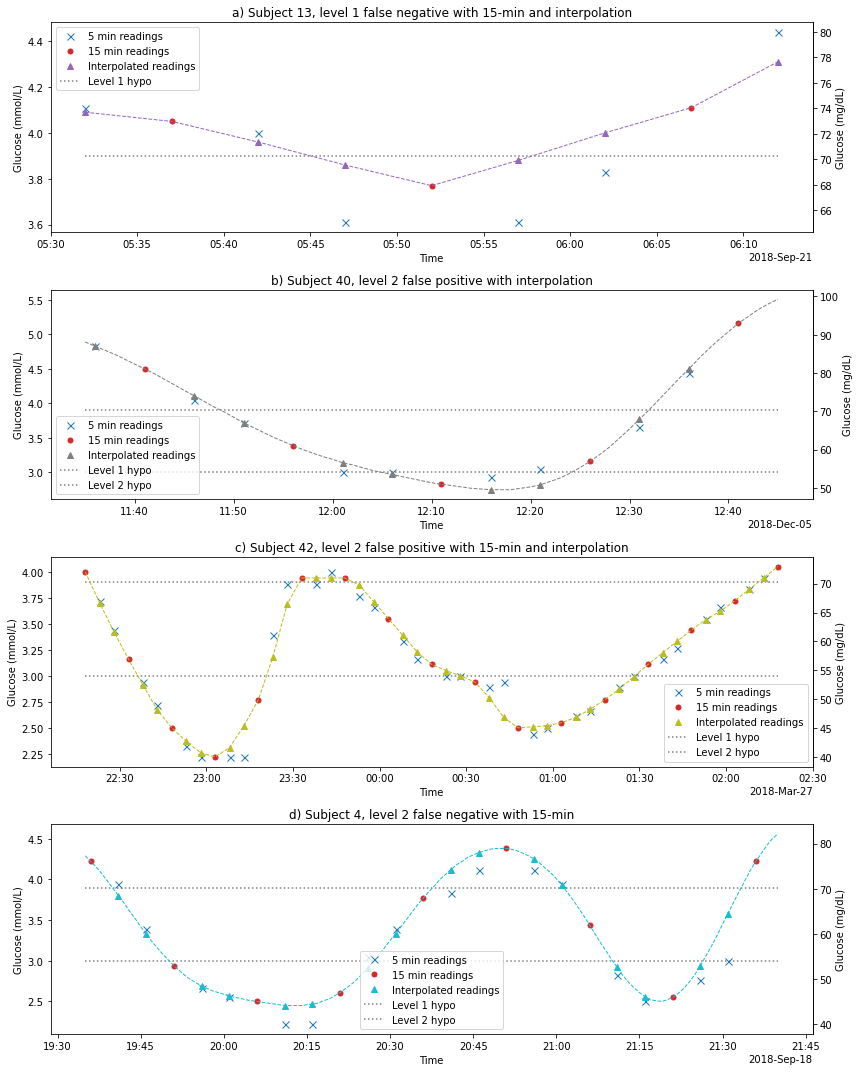

In [227]:
# Create figure and set title of each subplot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 15))
ax1 = create_ax(sub_dfs[0], ax1, 'linear', 'C4', False)
ax1.set_title('a) Subject 13, level 1 false negative with 15-min and interpolation')
ax2 = create_ax(sub_dfs[1], ax2, 'polynomial_5', 'C7', True)
ax2.set_title('b) Subject 40, level 2 false positive with interpolation')
ax3 = create_ax(sub_dfs[2], ax3, 'pchip', 'C8', True)
ax3.set_title('c) Subject 42, level 2 false positive with 15-min and interpolation')
ax4 = create_ax(sub_dfs[3], ax4, 'rbf', 'C9', True)
ax4.set_title('d) Subject 4, level 2 false negative with 15-min')

for ax in ax1, ax2, ax3, ax4:
    secax = ax.secondary_yaxis('right', functions=(mmol2mg, mg2mmol))
    secax.set_ylabel('Glucose (mg/dL)')
fig.tight_layout()
fig.savefig('fn_tp_examples.png')

## 4.4. Distribution of incorrect results by type

In [48]:
def incorrect_subtypes(df_method):
    '''
    Calculate how many of the incorrect hypos are identified as other levels
    of hypo
    '''
    # Actual lv1, identified as lv2
    lv1_lv2 = df_method.loc[(df_method['5_min_lv2']==False) & 
                            (df_method['15_min_lv2']==True)].shape[0]
    # Actual lv2, identified as lv1
    lv2_lv1 = df_method.loc[(df_method['5_min_lv2']==True) & 
                            (df_method['15_min_lv2']==False)].shape[0]
    # Actual lv1, identified as not a hypo
    lv1_none = df_method.loc[(df_method['5_min_lv2']==False) & 
                             (pd.isnull(df_method['15_min_lv2']))].shape[0]
    # Actual no hypo, identified as lv1 hypo
    none_lv1 = df_method.loc[(pd.isnull(df_method['5_min_lv2'])) & 
                             (df_method['15_min_lv2']==False)].shape[0]
    # Actual lv2 hypo, identified as no hypo
    lv2_none = df_method.loc[(df_method['5_min_lv2']==True) & 
                             (pd.isnull(df_method['15_min_lv2']))].shape[0] 
    # Actual no hypo, identified as level 2 hypo
    none_lv2 = df_method.loc[(pd.isnull(df_method['5_min_lv2'])) & 
                             (df_method['15_min_lv2']==True)].shape[0]
    return pd.DataFrame([[lv1_lv2, lv2_lv1,  lv1_none, none_lv1, lv2_none, 
                          none_lv2]])

In [49]:
# Call incorrect_subtypes and rename columns
results = aligned_results.groupby('col').apply(incorrect_subtypes).unstack()
results.columns=['lv1_lv2', 'lv2_lv1', 'lv1_none','none_lv1', 'lv2_none', 
                 'none_lv2']

In [50]:
# Shows the distibution of incorrectly identified hypos
# Columns show actual_predicted
results

,lv1_lv2,lv2_lv1,lv1_none,none_lv1,lv2_none,none_lv2
col,,,,,,
akima,8,8,11,13,0,1
cubicspline,12,7,9,14,0,1
cut_glc,0,18,33,1,3,1
linear,3,14,19,5,0,1
matern,12,6,8,17,1,1
pchip,8,10,10,9,0,1
polynomial_3,12,7,9,14,0,1
polynomial_5,13,6,8,16,0,1
polynomial_7,13,6,10,17,0,1


## 4.5. Distribution of incorrect results by person

In [52]:
# Combine baseline and 6-month periods for IDs
df['ID_code'] = df.ID.apply(lambda x: x[:4])
aligned_results['ID_code'] = aligned_results.ID.apply(lambda x: x[:4])

In [53]:
def number_false_values(sub_id):
    '''
    Calculate the number of people who have different types of incorrect hypos
    '''
    # Number of incorrect results per person (all)
    FN_all = sub_id.loc[sub_id.false_value == -1].shape[0]
    TP_all = sub_id.loc[sub_id.false_value == 0].shape[0]
    FP_all = sub_id.loc[sub_id.false_value == 1].shape[0]
    # Number of incorrect results per person (level 1)
    TPlv1 = sub_id[((sub_id['5_min_lv2'] == False) & 
                    (sub_id['15_min_lv2'] == False))].shape[0]
    FNlv1 = sub_id[(sub_id['5_min_lv2'] == False) & 
                   (sub_id['15_min_lv2'] != False)].shape[0]
    FPlv1 = sub_id[(sub_id['5_min_lv2'] != False) & 
                   (sub_id['15_min_lv2'] == False)].shape[0]
    # Number of incorrect results per person (level 2)
    TPlv2 = sub_id[((sub_id['5_min_lv2'] == True) & 
                    (sub_id['15_min_lv2'] == True))].shape[0]
    FNlv2 = sub_id[(sub_id['5_min_lv2'] == True) & 
                   (sub_id['15_min_lv2'] != True)].shape[0]
    FPlv2 = sub_id[(sub_id['5_min_lv2'] != True) & 
                   (sub_id['15_min_lv2'] == True)].shape[0]
    
    return pd.DataFrame([[TP_all, FP_all, FN_all, TPlv1, FPlv1, FNlv1, TPlv2,
                          FPlv2, FNlv2]], columns=['TP_all', 'FP_all',
                                                   'FN_all', 'TPlv1', 'FPlv1',
                                                   'FNlv1', 'TPlv2', 'FPlv2',
                                                   'FNlv2'])

In [54]:
# Call number_false_values for each ID
results_personal = aligned_results.groupby(['ID_code', 'col'], dropna=False).apply(number_false_values).reset_index().drop(columns='level_2')
results_personal

,ID_code,col,TP_all,FP_all,FN_all,TPlv1,FPlv1,FNlv1,TPlv2,FPlv2,FNlv2
0,1003,akima,19,0,0,11,1,0,7,0,1
1,1003,cubicspline,19,0,0,11,0,0,8,0,0
2,1003,cut_glc,19,0,0,11,1,0,7,0,1
3,1003,linear,19,0,0,11,1,0,7,0,1
4,1003,matern,19,0,0,11,0,0,8,0,0
5,1003,pchip,19,0,0,11,1,0,7,0,1
6,1003,polynomial_3,19,0,0,11,0,0,8,0,0
7,1003,polynomial_5,19,0,0,11,0,0,8,0,0
8,1003,polynomial_7,19,0,0,11,0,0,8,0,0
9,1003,rbf,19,0,0,11,0,0,8,0,0


In [56]:
# Melt the dataframe to calculate the number of people who have incorrect 
# values, this shows us the distribution of incorrect results 
melted = results_personal.melt(id_vars=['ID_code', 'col'])
pd.DataFrame(melted.groupby(['col', 'variable']).apply(lambda x: x[x.value!=0].shape[0])).reset_index().pivot(index='col', columns='variable')

0                                                  
variable     FN_all FNlv1 FNlv2 FP_all FPlv1 FPlv2 TP_all TPlv1 TPlv2
col                                                                  
akima            10    15     8     11    18     8     62    60    49
cubicspline       9    15     7     12    17    11     62    60    49
cut_glc          29    26    20      2    18     1     62    60    47
linear           16    18    14      5    18     3     62    60    48
matern            9    15     7     14    17    12     62    60    49
pchip             9    15    10      8    16     8     62    60    48
polynomial_3      9    15     7     12    17    11     62    60    49
polynomial_5      8    16     6     14    17    13     62    60    49
polynomial_7     10    17     6     14    17    13     62    60    49
rbf              11    17     6     13    16    11     62    60    49
rq               15    19    12      9    19     7     62    60    48